# Usage

## Model

To use models provided in TfChat, you first need to create a config object which handles hyper parameters of the model.

In [1]:
from tfchat.configs import GPT2SmallConfig
config = GPT2SmallConfig()
config

GPT2SmallConfig(num_layers=12, d_model=768, num_heads=12, d_ff=3072, vocab_size=50257, context_size=1024, attention_dropout_rate=0.1, residual_dropout_rate=0.1, embedding_dropout_rate=0.1, epsilon=1e-06)

You can overwrite the hyper parameters if necessary.

In [2]:
config.vocab_size = 10000
config

GPT2SmallConfig(num_layers=12, d_model=768, num_heads=12, d_ff=3072, vocab_size=10000, context_size=1024, attention_dropout_rate=0.1, residual_dropout_rate=0.1, embedding_dropout_rate=0.1, epsilon=1e-06)

You can also initialize your own config object from scratch.

In [3]:
from tfchat.configs import Config

config = Config(num_layers=6, d_model=64, num_heads=1, d_ff=256, vocab_size=100,
                context_size=64, attention_dropout_rate=0.1, residual_dropout_rate=0.1,
                embedding_dropout_rate=0.1, epsilon=1e-06)
config

Config(num_layers=6, d_model=64, num_heads=1, d_ff=256, vocab_size=100, context_size=64, attention_dropout_rate=0.1, residual_dropout_rate=0.1, embedding_dropout_rate=0.1, epsilon=1e-06)

Let us use this small config here for running faster in this example.

After preparing your config object, you can create the model with the config object.
TfChat currently provides two types of models which use decoder-side Transformer called Pre-LN and Post-LN Transformer, which are explained in [Xiong+, 2020].
Here is an example of using Pre-LN Transformer.

In [4]:
from tfchat.models import PreLNDecoder
model = PreLNDecoder(config)

The models can be used in the usual manner of TensorFlow Keras API.

In [5]:
import tensorflow.keras as keras
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.Adam())
model.build(input_shape=(None, config.context_size))
model.summary()

Model: "pre_ln_decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder (Decoder)            multiple                  312804    
Total params: 312,804
Trainable params: 312,804
Non-trainable params: 0
_________________________________________________________________


To train the models, you need to provide the data. The data consists of several samples, and each sample is a array of ids with `(config.context_size, )` shape.

For example, assume that context size = 3.
When a sentence "Nice to meet you" can be encoded as `[3, 4, 5, 6]`. Then the sample for input is `[3, 4, 5]` and the target label is `[4, 5, 6]`.

In the following example, `contexts` is a dummy data for four encoded sentences. You can substitute your own data there.

After preparing data, you can use `fit` method to train your model.

In [6]:
import numpy as np
contexts = np.ones((4, config.context_size+1), dtype=np.int32)  # This is dummy data. Replace with your data
train_X = contexts[:,:-1]
train_y = contexts[:,1:]
history = model.fit(train_X, train_y, batch_size=2)

2/2 [==============================] - 0s 15ms/step - loss: 5.9452


Finally, let us generate outputs from your inputs!
`TopKTopPGenerator` allows you to generate outputs from inputs with Top-p (Nucleus) Sampling introduced in [Holtzman+, 2019].

In [7]:
from tfchat.generations import TopKTopPGenerator
gen = TopKTopPGenerator(model=model, max_len=3)
inputs = np.array([[1, 1, 1, 1, 1]], dtype=np.int32)
gen.generate(inputs)

array([[1, 1, 1, 1, 1, 1, 1, 1]])

## Utility

TfChat provides not only models but also utilities to help users train.

### Dataset

Preparing input data usually takes time. For typical input data, TfChat provides useful classes under `tfchat.data`.

One of them is `BlockDataset`.
This class is for creating dataset to train a language model with large documents (e.g. Wikipedia)
After you prepare the ids of encoded documents, `BlockDataset` split the data into `block_size` and batch them.

For example, you have ids as `[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]`. For applying `BlockDataset.build` method with `block_size=5` and `batch_size=2`,
then the output is [tensorflow.data.Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset)
which consists of tuple `([[0, 1, 2, 3, 4], [5, 6, 7, 8, 9]], [[1, 2, 3, 4, 5], [6, 7, 8, 9, 10]])`.
The first item is the input, and the second one is the target label.

Let's take a look at this example.

In [8]:
from tfchat.data import BlockDataset
dataset = BlockDataset(block_size=5, batch_size=2)
ids = list(range(11))
ids

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [9]:
for item in dataset.build(ids, shuffle=False):
    print(item)

(<tf.Tensor: shape=(2, 5), dtype=int32, numpy=
array([[0, 1, 2, 3, 4],
       [5, 6, 7, 8, 9]], dtype=int32)>, <tf.Tensor: shape=(2, 5), dtype=int32, numpy=
array([[ 1,  2,  3,  4,  5],
       [ 6,  7,  8,  9, 10]], dtype=int32)>)


You can set `shuffle` argument for `build` method to decide shuffle the samples or not.
This is useful to build validation data without shuffling as follow.

In [10]:
train_ids = np.ones(512, dtype=np.int32)  # Prepare token ids for training data
valid_ids = np.ones(512, dtype=np.int32)  # Prepare token ids for validation data
dataset = BlockDataset(block_size=config.context_size, batch_size=2)

train_dataset = dataset.build(train_ids, shuffle=True)
valid_dataset = dataset.build(valid_ids, shuffle=False)

You can use dataset in the `fit` method in the usual manner.

In [11]:
history = model.fit(train_dataset, validation_data=valid_dataset)

3/3 [==============================] - 2s 539ms/step - loss: 2.4182e-04 - val_loss: 0.0000e+00


### Loss

To ignore padding value `0` in the loss, `PaddingLoss` can be used.

In [12]:
from tfchat.losses import PaddingLoss
model.compile(loss=PaddingLoss(), optimizer=keras.optimizers.Adam())

### Schedule

`WarmupLinearDecay` is a learning rate scheduler which linearly decays the learning rate with warmup steps.

In [13]:
from tfchat.schedules import WarmupLinearDecay
schedule = WarmupLinearDecay(max_learning_rate=1e-3, warmup_steps=1000, training_steps=10000)

Text(0.5, 0, 'Train Step')

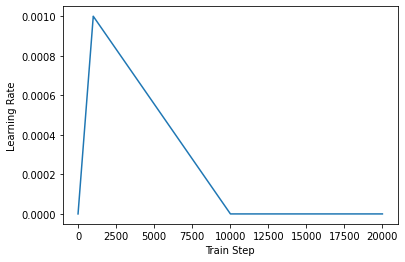

In [14]:
import matplotlib.pyplot as plt

plt.plot(schedule(np.arange(20000, dtype=np.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

The scheduler can be used with optimizer.

In [18]:
optimizer = keras.optimizers.Adam(schedule,
                                  beta_1=0.9,
                                  beta_2=0.999,
                                  epsilon=1e-8,
                                  clipnorm=1.0)

### Evaluation

After finish training your model, use `perplexity` function to evaluate your model.

In [19]:
from tfchat.metrics import perplexity
perplexity(model, valid_dataset)

{'loss': 0.0, 'perplexity': 1.0, 'num_batches': 3, 'num_tokens': 384}


1.0